In [3]:
import pickle
import pandas as pd
import numpy as np
import os.path as osp
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import xarray as xr

from utils.basics import task_cmap_caps
from utils.basics import PNAS2015_subject_list, PRJ_DIR, input_datas

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ms = np.array([2,3,5,10,15,20,25])

***
# Results for LE - Scan-Level

In [5]:
%%time
LE_F1     = pd.DataFrame(columns=['Input','Subject','m','Classifier','F1','F1_a','F1_b'])
LE_COEFFS = {}
for m in tqdm(ms,desc='Max Dimensions'):
    for input_data in input_datas:
        for clf in ['logisticregression','svc']:
            LE_COEFFS[(m,input_data,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':PNAS2015_subject_list,'Dimension':['LE'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
            for sbj in PNAS2015_subject_list:
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',sbj,'Classification','LE',input_data,'{sbj}_Craddock_0200.WL045s.WS1.5s.LE_correlation_k0075_m{m}.zscored.clf_results.{clf}_WindowName.pkl'.format(sbj=sbj,m=str(m).zfill(4),clf=clf))
                with open(path,'rb') as f:
                    objects = pickle.load(f)
                locals().update(objects)
                # Gather overall F1 - score
                # =========================
                LE_F1 = LE_F1.append({'Subject':sbj,'Input':input_data,'m':m,'Classifier':clf,
                                      'F1':cv_obj['test_f1_weighted'].mean(),
                                      'F1_a':(cv_obj['test_f1_weighted'][[0,1]]).mean(),
                                      'F1_b':(cv_obj['test_f1_weighted'][[2,3]]).mean(),}, ignore_index=True)
                
                # Coefficients
                # ============
                df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                for split in range(4):
                    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                    aux_coef  = cv_obj['estimator'][split][clf].coef_
                    for ci,c in enumerate(aux_class):
                        for i in range(aux_coef.shape[1]):
                            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                df_coeffs.reset_index(inplace=True)
                df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                LE_COEFFS[(m,input_data,clf)].loc[sbj,:,:] = df_coeffs
                del df_coeffs

Max Dimensions:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 3min 59s, sys: 297 ms, total: 3min 59s
Wall time: 4min 16s


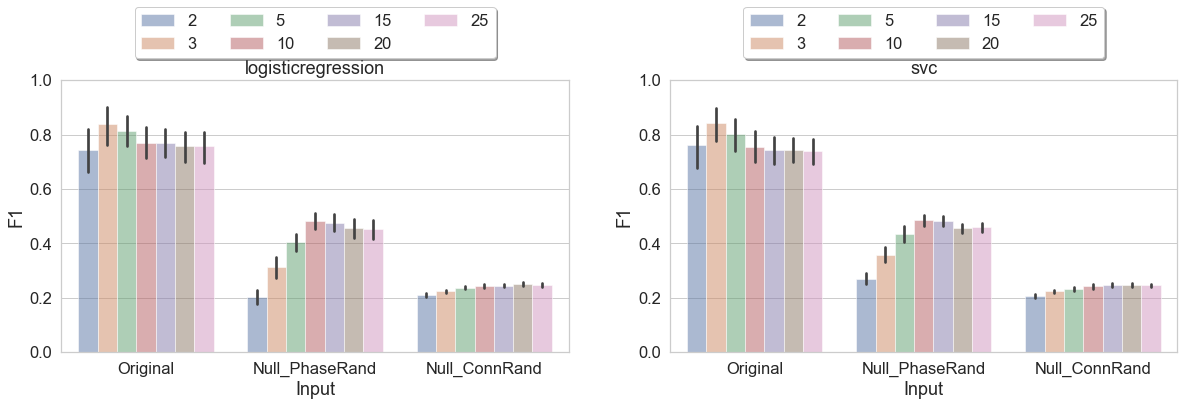

In [9]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = LE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i], alpha=0.5)
    #g = sns.swarmplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

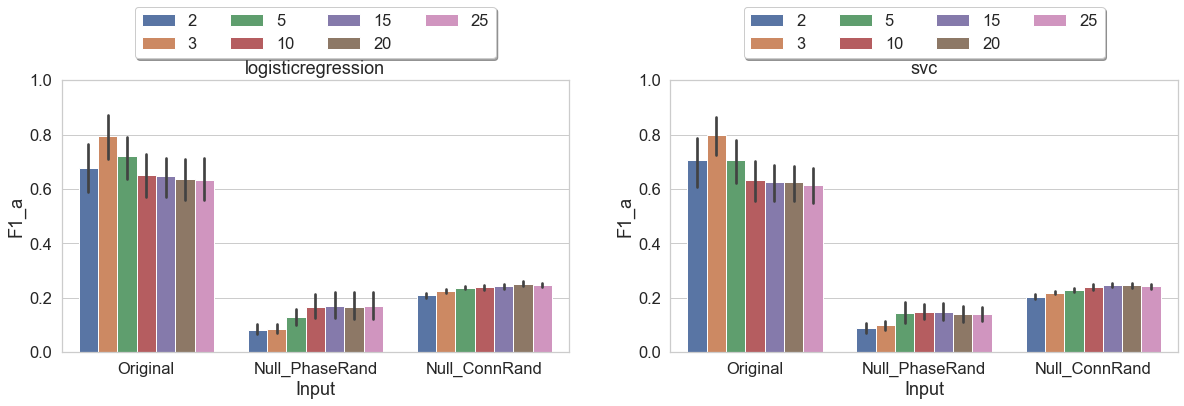

In [7]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = LE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_a',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

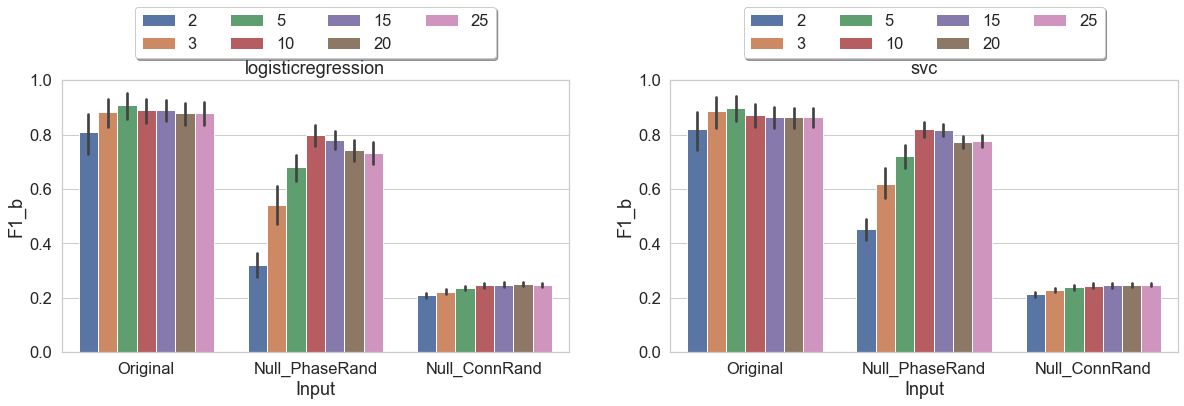

In [8]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = LE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_b',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

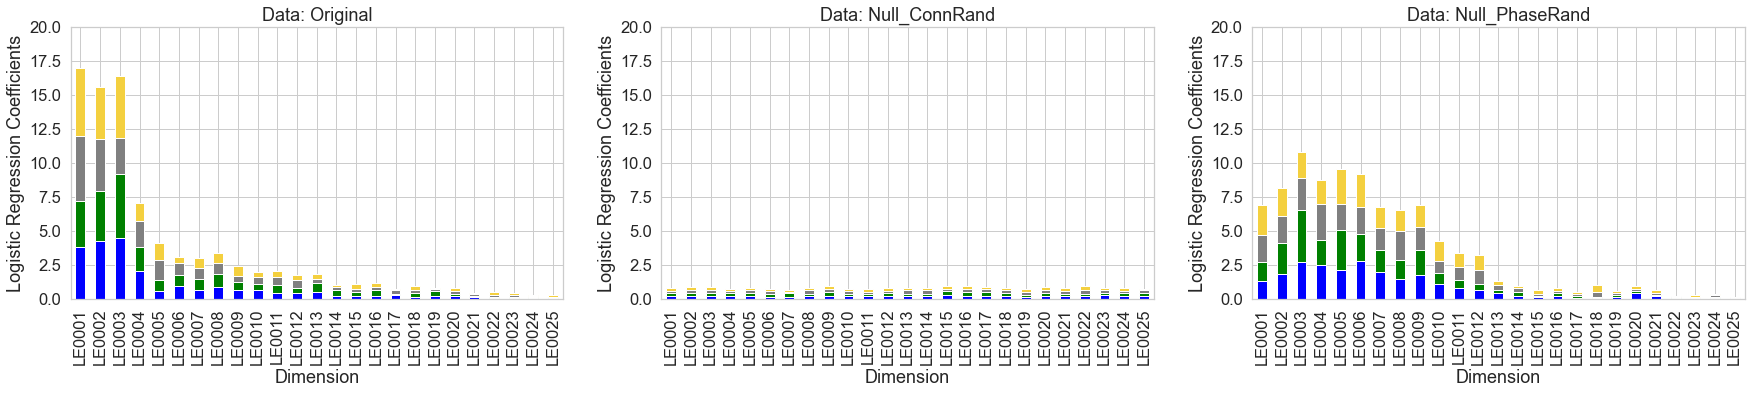

In [5]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,3,figsize=(30,5))
for i, input_data in enumerate(input_datas):
    df_summary = LE_COEFFS[(25,input_data,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
    df_summary = df_summary.groupby(by=['Class','Dimension']).mean()
    df_summary.reset_index(inplace=True)
    df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
    df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=axs[i])
    axs[i].set_ylabel('Logistic Regression Coefficients')
    axs[i].set_ylim(0,20)
    axs[i].set_title('Data: %s' % input_data)

***
# Results for UMAP - Scan-Level

In [7]:
%%time
UMAP_F1     = pd.DataFrame(columns=['Input','Subject','m','Classifier','F1'])
UMAP_COEFFS = {}
for m in tqdm(ms,desc='Max Dimensions'):
    for input_data in input_datas:
        for clf in ['logisticregression','svc']:
            UMAP_COEFFS[(m,input_data,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':PNAS2015_subject_list,'Dimension':['UMAP'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
            for sbj in PNAS2015_subject_list:
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',sbj,'Classification','UMAP',input_data,'{sbj}_Craddock_0200.WL045s.WS1.5s.UMAP_euclidean_k0070_m{m}_md0.8_a0.01_spectral.asis.clf_results.{clf}_WindowName.pkl'.format(sbj=sbj,m=str(m).zfill(4),clf=clf))
                with open(path,'rb') as f:
                    objects = pickle.load(f)
                locals().update(objects)
                # Gather overall F1 - score
                # =========================
                UMAP_F1 = UMAP_F1.append({'Subject':sbj,'Input':input_data,'m':m,'Classifier':clf,
                                         'F1':cv_obj['test_f1_weighted'].mean(),
                                         'F1_a':(cv_obj['test_f1_weighted'][[0,1]]).mean(),
                                         'F1_b':(cv_obj['test_f1_weighted'][[2,3]]).mean(),},ignore_index=True)
                # Coefficients
                # ============
                df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                for split in range(4):
                    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                    aux_coef  = cv_obj['estimator'][split][clf].coef_
                    for ci,c in enumerate(aux_class):
                        for i in range(aux_coef.shape[1]):
                            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                df_coeffs.reset_index(inplace=True)
                df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                UMAP_COEFFS[(m,input_data,clf)].loc[sbj,:,:] = df_coeffs
                del df_coeffs

Max Dimensions:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 4min, sys: 206 ms, total: 4min
Wall time: 4min 15s


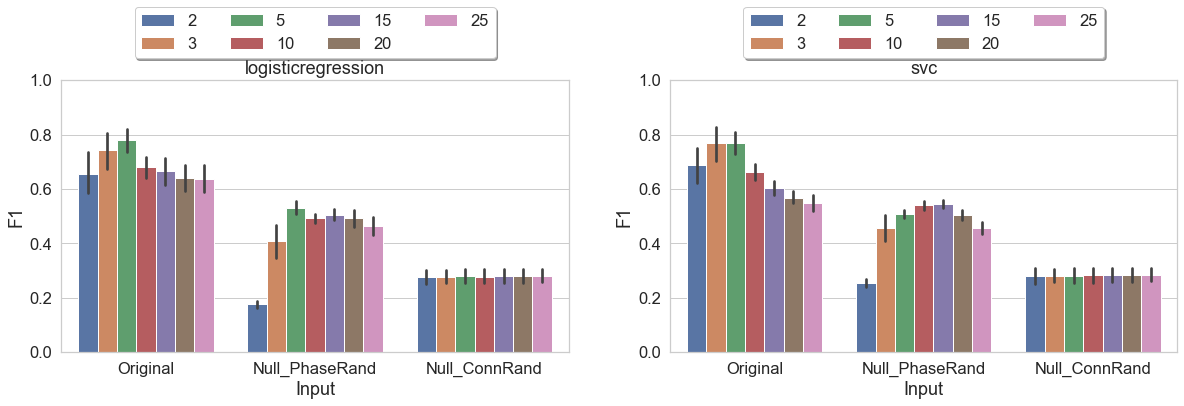

In [8]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = UMAP_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

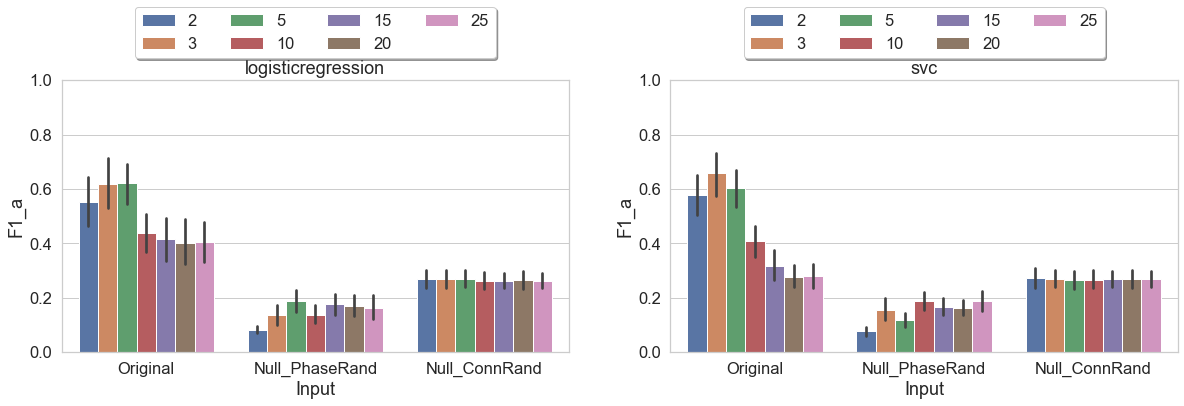

In [9]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = UMAP_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_a',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

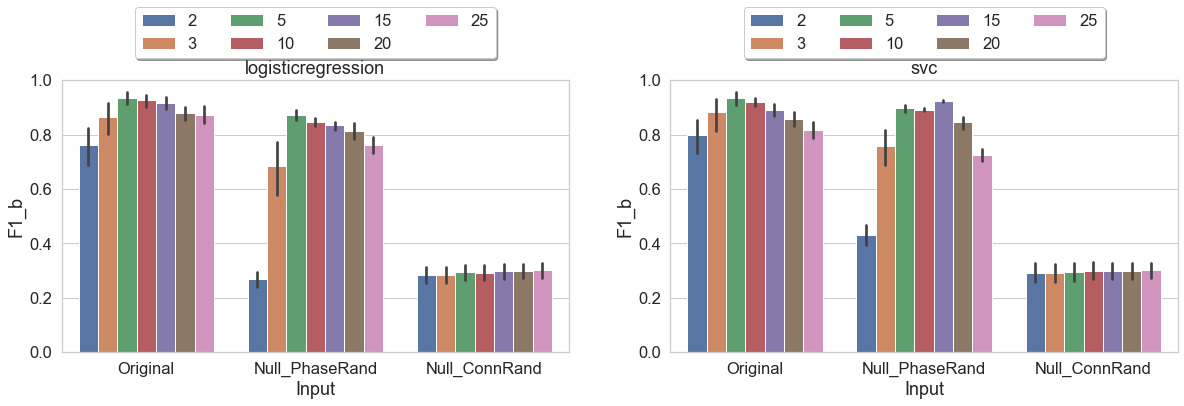

In [10]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = UMAP_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_b',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

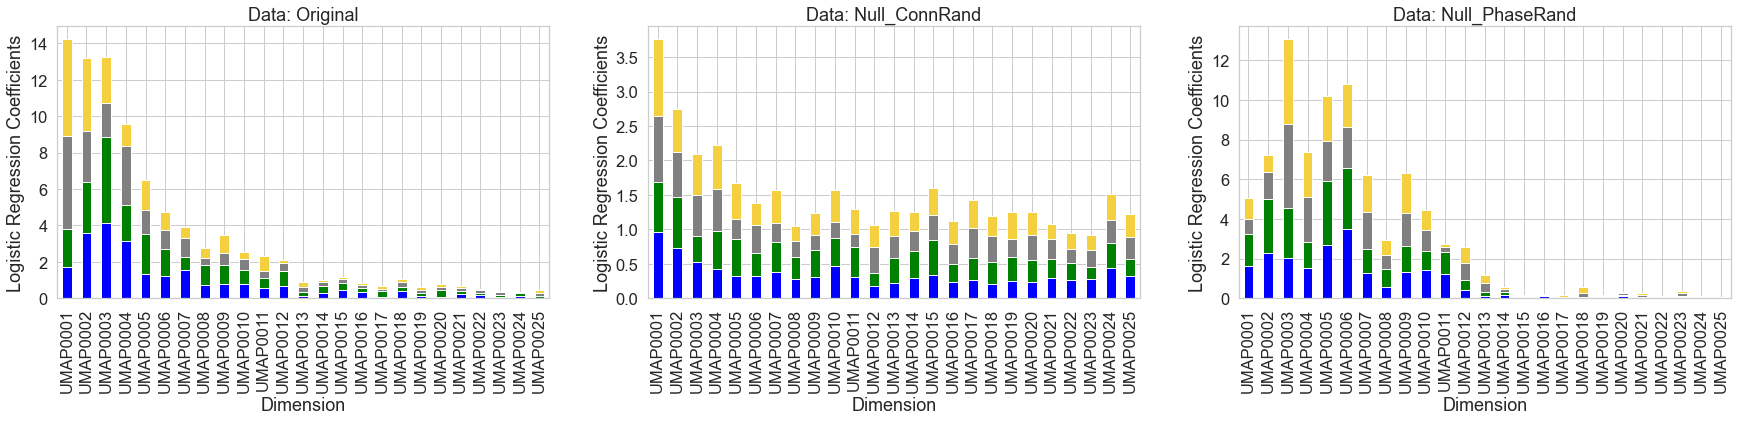

In [11]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,3,figsize=(30,5))
for i, input_data in enumerate(input_datas):
    df_summary = UMAP_COEFFS[(25,input_data,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
    df_summary = df_summary.groupby(by=['Class','Dimension']).mean()
    df_summary.reset_index(inplace=True)
    df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
    df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=axs[i])
    axs[i].set_ylabel('Logistic Regression Coefficients')
    #axs[i].set_ylim(0,20)
    axs[i].set_title('Data: %s' % input_data)

***
# Results for TSNE - Scan-Level

In [12]:
%%time
TSNE_F1     = pd.DataFrame(columns=['Input','Subject','m','Classifier','F1','F1_a','F1_b'])
TSNE_COEFFS = {}
for m in tqdm(ms,desc='Max Dimensions'):
    for input_data in input_datas:
        for clf in ['logisticregression','svc']:
            TSNE_COEFFS[(m,input_data,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':PNAS2015_subject_list,'Dimension':['TSNE'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
            for sbj in PNAS2015_subject_list:
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',sbj,'Classification','TSNE',input_data,'{sbj}_Craddock_0200.WL045s.WS1.5s.TSNE_correlation_pp0070_m{m}_a10_pca.asis.clf_results.{clf}_WindowName.pkl'.format(sbj=sbj,m=str(m).zfill(4),clf=clf))
                with open(path,'rb') as f:
                    objects = pickle.load(f)
                locals().update(objects)
                # Gather overall F1 - score
                # =========================
                TSNE_F1 = TSNE_F1.append({'Subject':sbj,'Input':input_data,'m':m,'Classifier':clf,
                                          'F1':cv_obj['test_f1_weighted'].mean(),
                                          'F1_a':(cv_obj['test_f1_weighted'][[0,1]]).mean(),
                                          'F1_b':(cv_obj['test_f1_weighted'][[2,3]]).mean(),}, ignore_index=True)
                # Coefficients
                # ============
                df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                for split in range(4):
                    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                    aux_coef  = cv_obj['estimator'][split][clf].coef_
                    for ci,c in enumerate(aux_class):
                        for i in range(aux_coef.shape[1]):
                            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                df_coeffs.reset_index(inplace=True)
                df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                TSNE_COEFFS[(m,input_data,clf)].loc[sbj,:,:] = df_coeffs
                del df_coeffs

Max Dimensions:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 3min 59s, sys: 114 ms, total: 3min 59s
Wall time: 4min


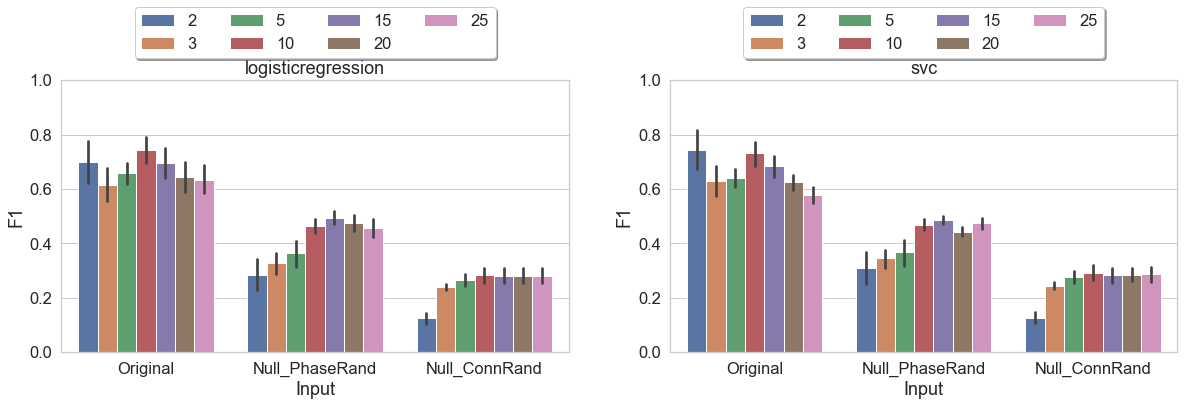

In [13]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = TSNE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

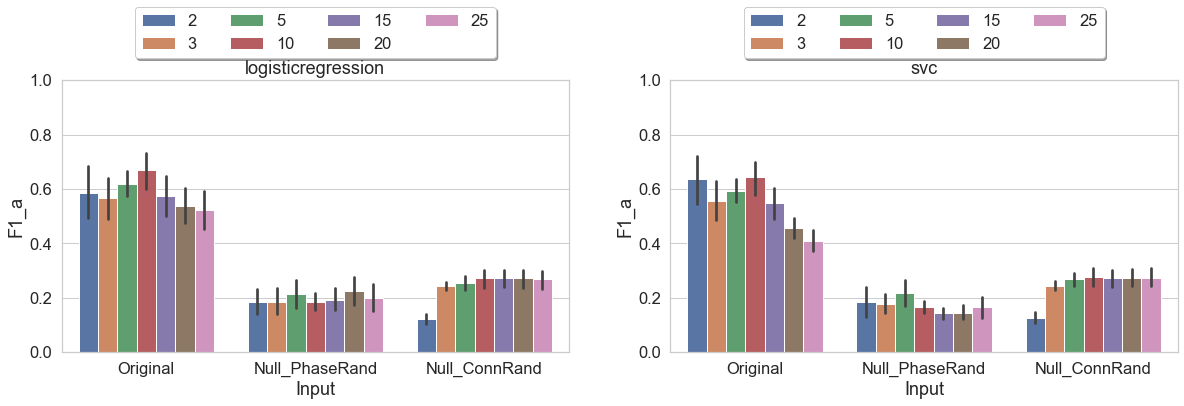

In [14]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = TSNE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_a',x='Input',hue='m', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

NameError: name 'TSNE_F1' is not defined

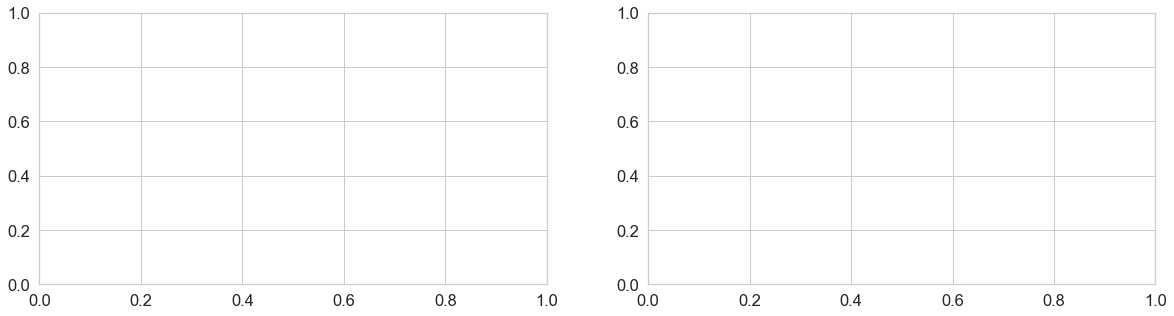

In [23]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = TSNE_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_b',x='Input',hue='m', ax=axs[i], alpha=.5)
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

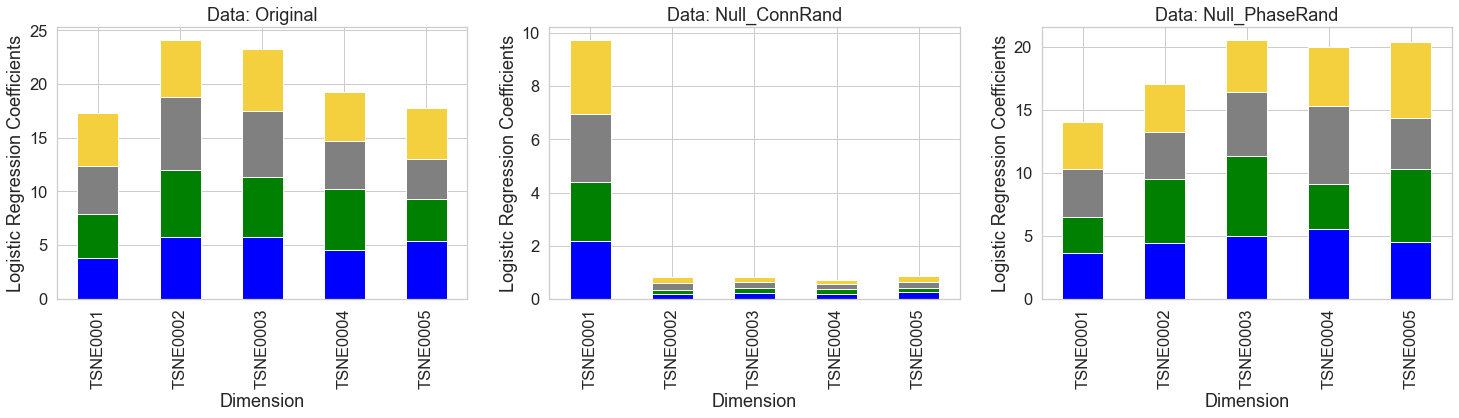

In [32]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,3,figsize=(25,5))
for i, input_data in enumerate(input_datas):
    df_summary = TSNE_COEFFS[(5,input_data,'logisticregression')].mean(dim='Subject').to_dataframe(name='Coeffs')
    df_summary = df_summary.groupby(by=['Class','Dimension']).mean()
    df_summary.reset_index(inplace=True)
    df_summary = df_summary.pivot(index='Class',columns='Dimension',values='Coeffs').T
    df_summary.plot(kind='bar',stacked=True, legend=None, color=task_cmap_caps, ax=axs[i])
    axs[i].set_ylabel('Logistic Regression Coefficients')
    #axs[i].set_ylim(0,20)
    axs[i].set_title('Data: %s' % input_data)

***
# SWC

In [11]:
%%time
SWC_F1     = pd.DataFrame(columns=['Input','Subject','Classifier','F1','F1_a','F1_b'])
SWC_COEFFS = {}
for input_data in input_datas:
        for clf in ['logisticregression','svc']:
            #SWC_COEFFS[(m,input_data,clf)] = xr.DataArray(dims=['Subject','Dimension','Class'], coords={'Subject':PNAS2015_subject_list,'Dimension':['TSNE'+str(i+1).zfill(4) for i in range(m)],'Class':['BACK','MATH','REST','VIDE']})
            for sbj in PNAS2015_subject_list:
                # Load Classification results
                # ===========================
                path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',sbj,'Classification','SWC',input_data,'{sbj}_Craddock_0200.WL045s.WS1.5s.tvFC.{mat_type}.{nm}.clf_results.{clf}_WindowName.pkl'.format(sbj=sbj,mat_type='Z',nm='asis',clf=clf))
                with open(path,'rb') as f:
                    objects = pickle.load(f)
                locals().update(objects)
                # Gather overall F1 - score
                # =========================
                SWC_F1 = SWC_F1.append({'Subject':sbj,'Input':input_data,'Classifier':clf,
                                          'F1':cv_obj['test_f1_weighted'].mean(),
                                          'F1_a':(cv_obj['test_f1_weighted'][[0,1]]).mean(),
                                          'F1_b':(cv_obj['test_f1_weighted'][[2,3]]).mean(),}, ignore_index=True)
                # Coefficients
                # ============
                #df_coeffs = pd.DataFrame(columns=['Split','Class','Dimension','Coef'])
                #for split in range(4):
                #    aux_class = list(lab_encs['Window Name'].inverse_transform(cv_obj['estimator'][split][clf].classes_))
                #    aux_coef  = cv_obj['estimator'][split][clf].coef_
                #    for ci,c in enumerate(aux_class):
                #        for i in range(aux_coef.shape[1]):
                #            df_coeffs = df_coeffs.append({'Split':split,'Class':c,'Dimension':feature_list[i],'Coef':abs(aux_coef[ci][i])},ignore_index=True)
                #df_coeffs = df_coeffs.groupby(by=['Class','Dimension']).mean()
                #df_coeffs.reset_index(inplace=True)
                #df_coeffs = df_coeffs.pivot(index='Class',columns='Dimension',values='Coef').T
                #SWC_COEFFS[(m,input_data,clf)].loc[sbj,:,:] = df_coeffs
                #del df_coeffs

CPU times: user 7.58 s, sys: 13.3 s, total: 20.9 s
Wall time: 39 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


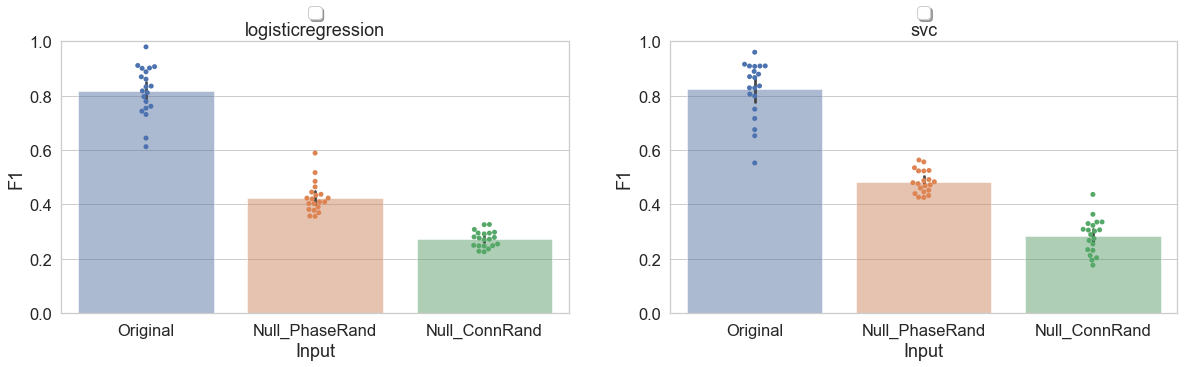

In [16]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = SWC_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1',x='Input', ax=axs[i], alpha=.5)
    g = sns.swarmplot(data=aux_df,y='F1',x='Input', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


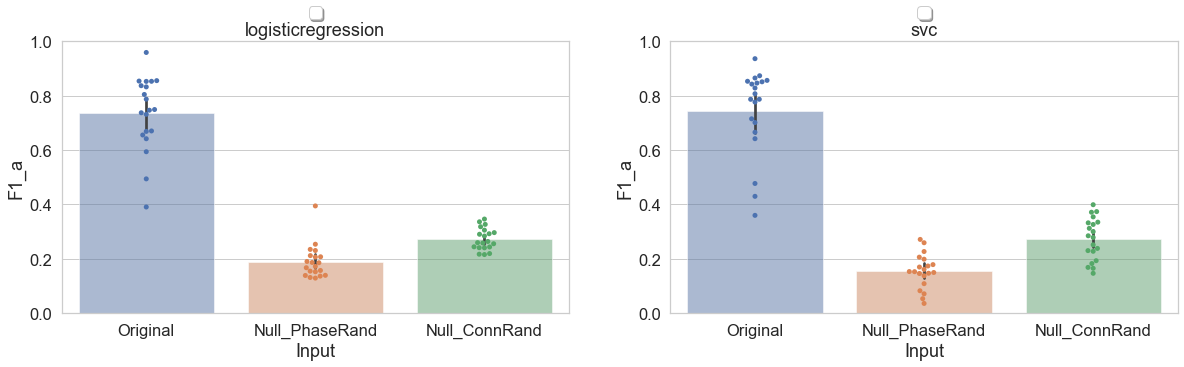

In [21]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = SWC_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_a',x='Input', ax=axs[i], alpha=.5)
    g = sns.swarmplot(data=aux_df,y='F1_a',x='Input', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


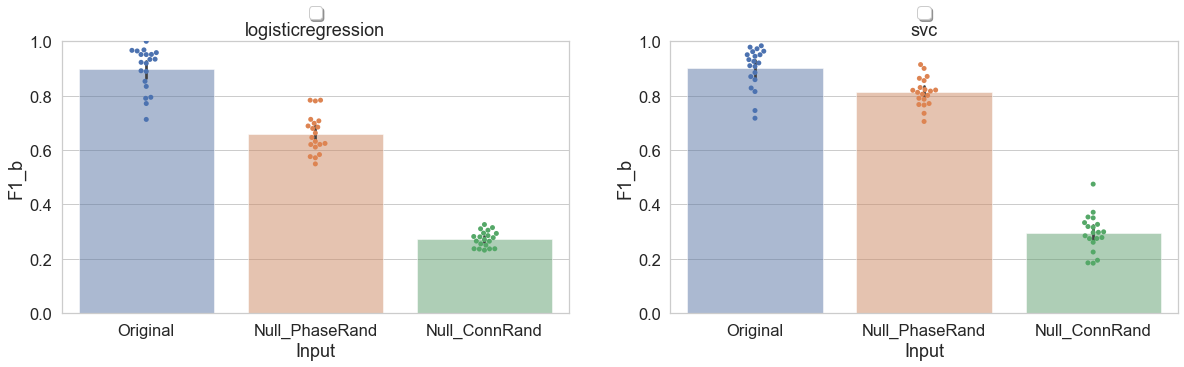

In [22]:
sns.set(font_scale=1.5, style='whitegrid')
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i,clf in enumerate(['logisticregression','svc']):
    aux_df = SWC_F1.set_index(['Classifier']).sort_index().loc[clf].sort_values(by='Input', ascending=False)
    g = sns.barplot(data=aux_df,y='F1_b',x='Input', ax=axs[i], alpha=.5)
    g = sns.swarmplot(data=aux_df,y='F1_b',x='Input', ax=axs[i])
    g.set_ylim(0,1)
    g.set_title(clf)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True)